In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")

In [2]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
data_location = '../../../neuralprophet-data/datasets/'

sf_load_df = pd.read_csv(data_location +  'energy/SF_hospital_load.csv')

In [3]:
sf_pv_df.head(3)

,ds,y
0,2015-01-01 01:00:00,0
1,2015-01-01 02:00:00,0
2,2015-01-01 03:00:00,0


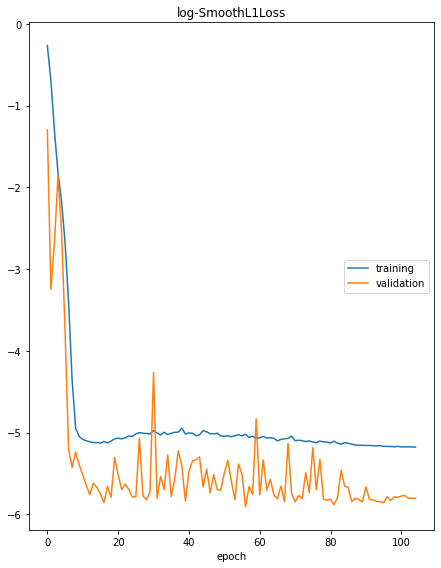

Epoch[105/105]: 100%|██████████████████████| 105/105 [00:48<00:00,  2.16it/s, SmoothL1Loss=0.00565, MAE=50.6, MSE=8.59e+3, RegLoss=0, MAE_val=41.3, MSE_val=4.58e+3, SmoothL1Loss_val=0.00301]


In [68]:
m = NeuralProphet(
    # n_lags=24,
    # ar_sparsity=0.5,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=8,
    seasonality_mode='multiplicative',
    learning_rate=0.03,
    #num_hidden_layers = 2,
    #d_hidden=20,
)
sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(sf_pv_df, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [70]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
104,0.005651,50.59902,8593.830239,0.0,0.003014,41.279392,4583.078125


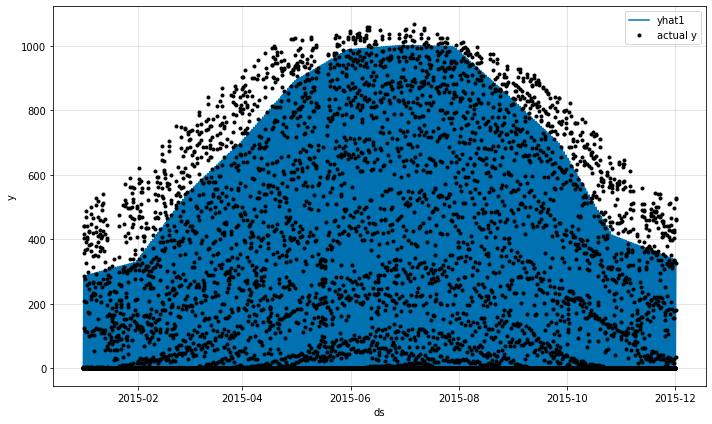

In [71]:
forecast = m.predict(sf_pv_df_train)
fig = m.plot(forecast)

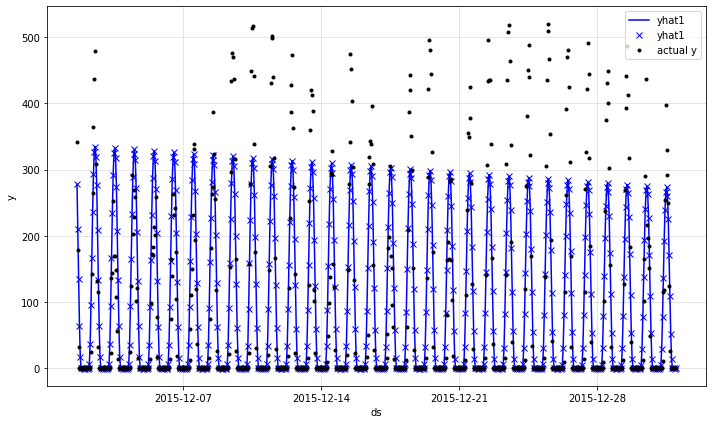

In [76]:
forecast = m.predict(sf_pv_df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

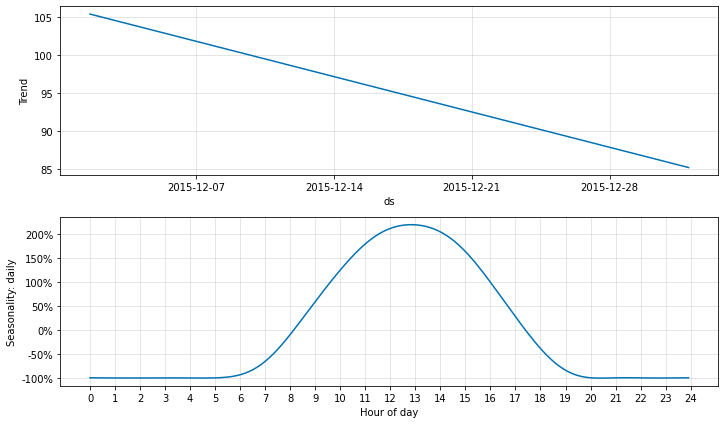

In [77]:
fig_comp = m.plot_components(forecast)

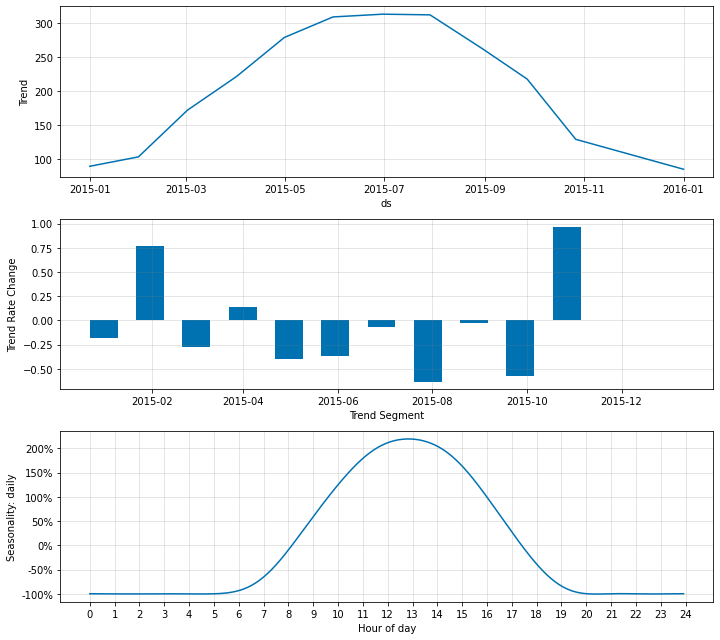

In [78]:
fig_param = m.plot_parameters()


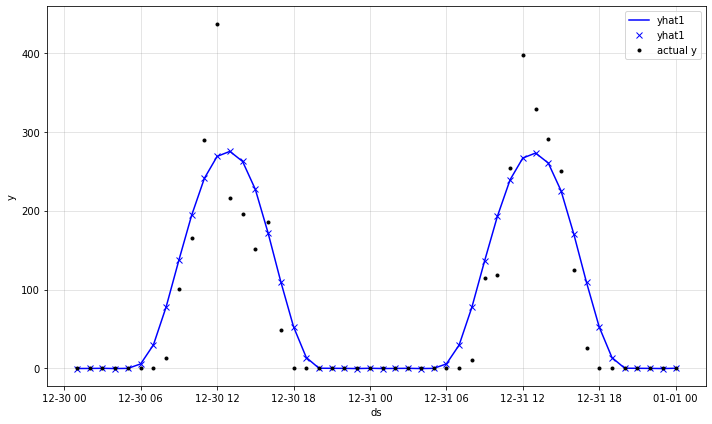

In [83]:
fig_prediction = m.plot(forecast[-48:])


There is something to consider here, if we consider a neural network with at least one hidden layer. For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.  

From below, we can see that the forecast output has a strange behavior. it looks like the output is exactly the sum of the weekly, daily seasonlality with trend. With no noise and changes at all.

In [37]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate = 0.1
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s, SmoothL1Loss=0.0097, MAE=96, MSE=1.48e+4, RegLoss=4.86e-5]


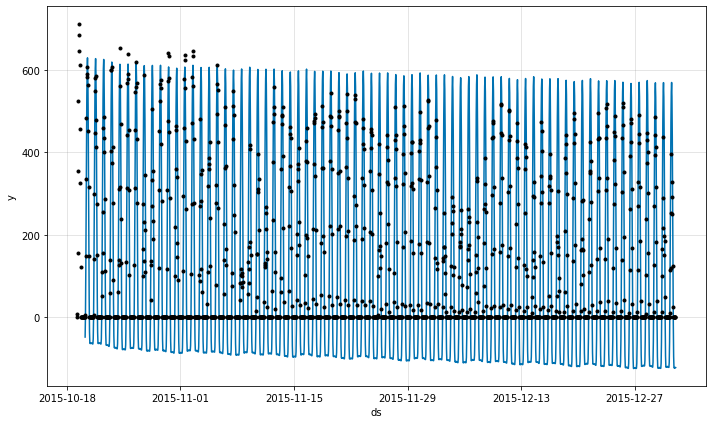

In [38]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

An easy fix is to set the learning rate at a low enough value.

In [39]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate = 0.001
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.34it/s, SmoothL1Loss=0.00158, MAE=26.3, MSE=2.41e+3, RegLoss=0.000998]


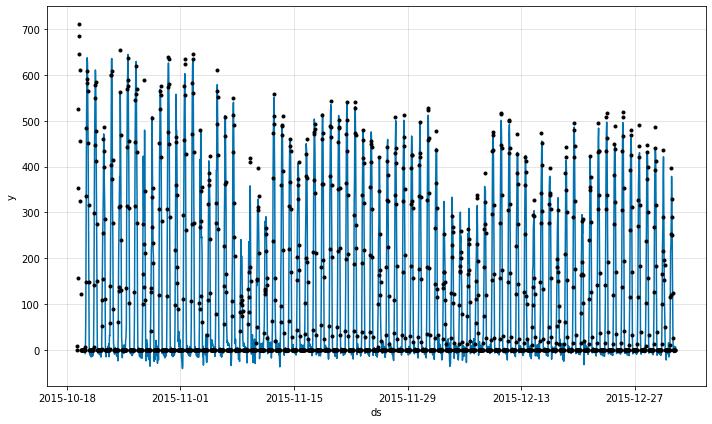

In [40]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

## Example on load forecasting

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building. We use a similar NeuralProphet model as we used for the PV forecasting.

In [41]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")
files = ['SanFrancisco_PV_GHI.csv', 'SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[1])

df=pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df.head(3)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338


In [42]:
print(raw)

      Electricity:Facility [kW](Hourly)
0                            778.007969
1                            776.241750
2                            779.357338
3                            778.737196
4                            787.835835
...                                 ...
8755                         845.563081
8756                         827.530521
8757                         829.256300
8758                         813.937205
8759                         815.588584

[8760 rows x 1 columns]


In [57]:
m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate=0.001
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 73
Epoch[73/73]: 100%|██████████| 73/73 [00:54<00:00,  1.33it/s, SmoothL1Loss=0.00049, MAE=13.4, MSE=354, RegLoss=0.000921]


In [58]:
df_train, df_val = m.split_df(df, freq='H',valid_p=0.2)
m.test(df_val)

INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE     MSE
1         0.001 13.704 374.965


,SmoothL1Loss,MAE,MSE
0,0.00052,13.703728,374.965097


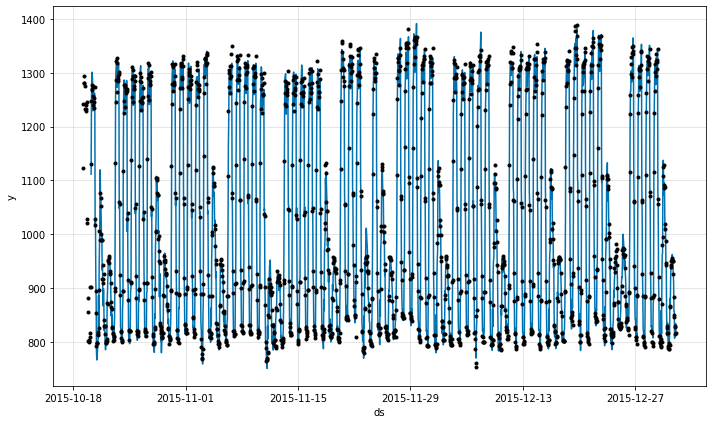

In [59]:
future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

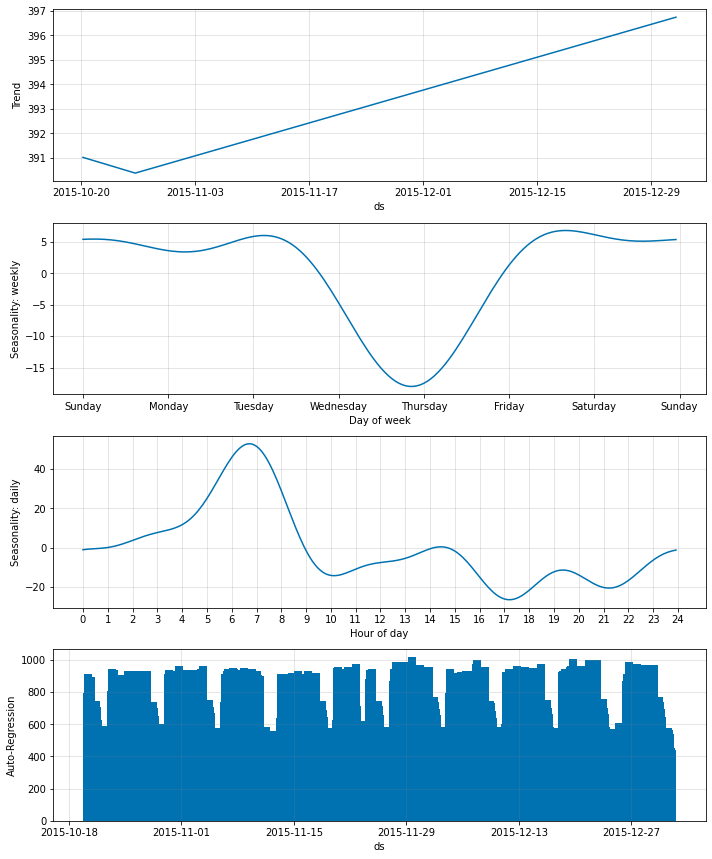

In [60]:
fig_comp = m.plot_components(forecast)


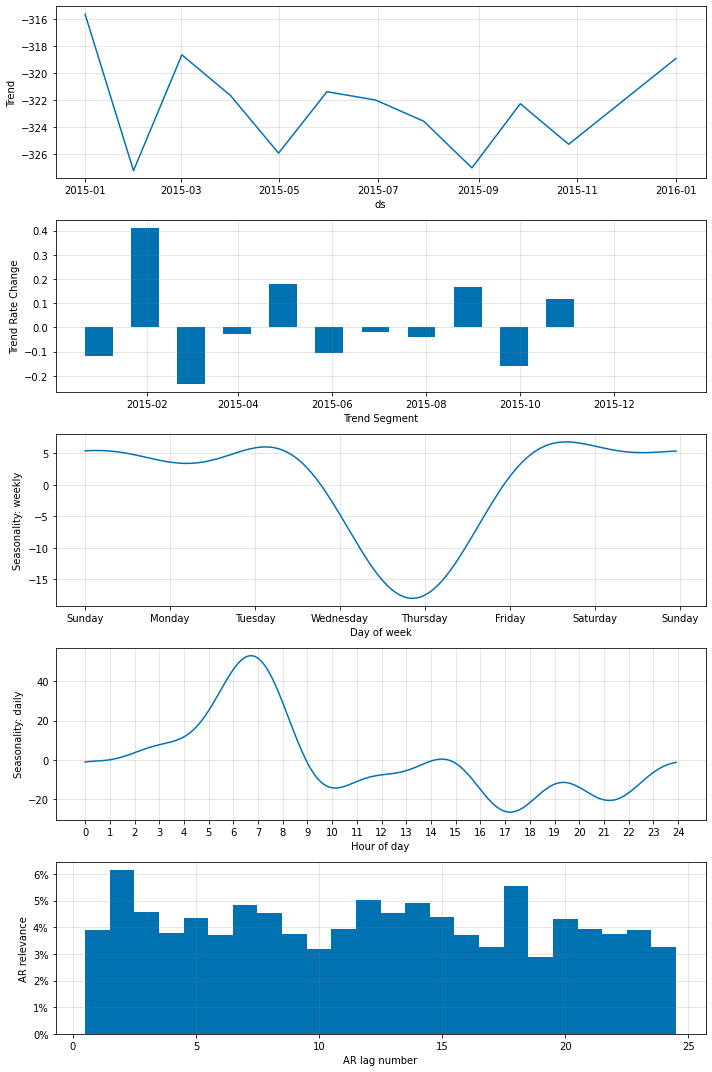

In [61]:
fig_param = m.plot_parameters()


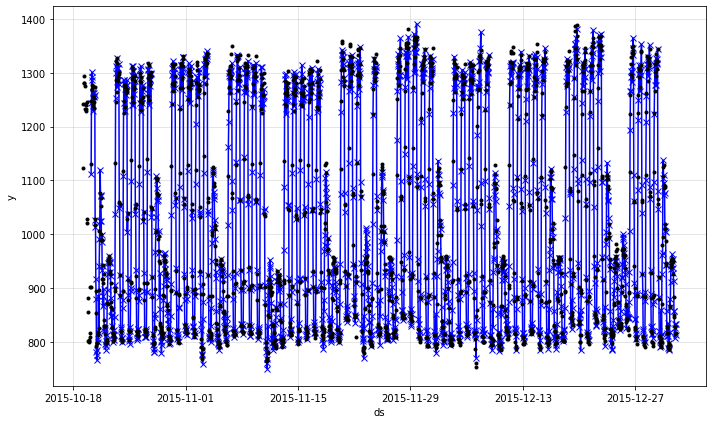

In [62]:
fig_fit = m.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)


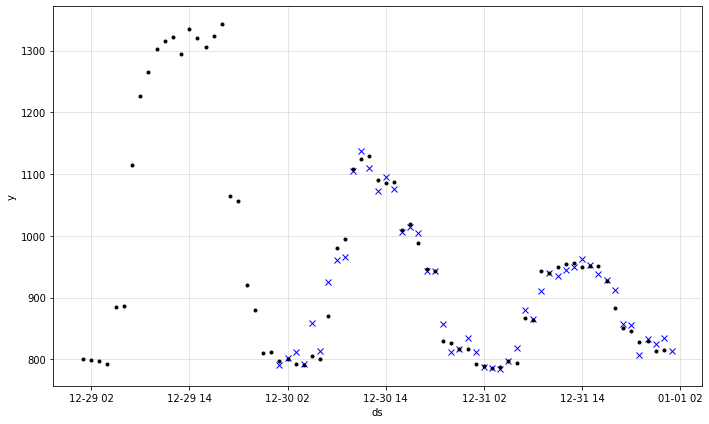

In [63]:
fig_prediction = m.plot_last_forecast(forecast, include_previous_forecasts=48)
